Accuracy Score 0.96

Counterfactual results for sample index 0:
Original prediction: 1
Target prediction:   0
Counterfactual input (x_cf): [-0.22337567  0.34295347]
Counterfactual prediction (y_cf): 0
Changes applied (delta): [-0.09522097  0.37669369]
Index 1: Counterfactual not found (No counterfactual found - Consider changing parameters 'regularization', 'features_whitelist', 'optimizer' and try again)

Counterfactual results for sample index 2:
Original prediction: 1
Target prediction:   0
Counterfactual input (x_cf): [-0.32759114 -0.16385386]
Counterfactual prediction (y_cf): 0
Changes applied (delta): [-0.32261339 -0.06805576]
Index 3: Counterfactual not found (No counterfactual found - Consider changing parameters 'regularization', 'features_whitelist', 'optimizer' and try again)

Counterfactual results for sample index 4:
Original prediction: 1
Target prediction:   0
Counterfactual input (x_cf): [ 0.32418349 -1.2548612 ]
Counterfactual prediction (y_cf): 0
Changes applied (delt

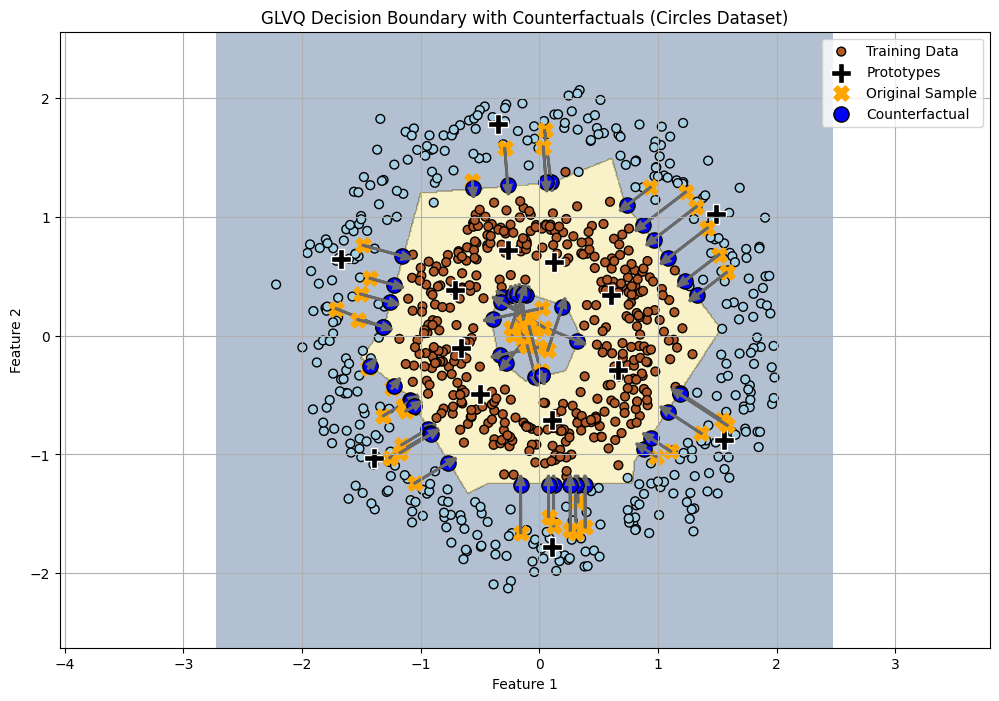

In [8]:
# Import necessary libraries
import random
import time
random.seed(42)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.utils import shuffle
from sklearn.datasets import make_circles
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn_lvq import GlvqModel, GmlvqModel, LgmlvqModel
from ceml.backend.jax.costfunctions import CostFunctionDifferentiableJax
from ceml.sklearn.lvq import LvqCounterfactual, lvq_generate_counterfactual
import jax.numpy as npx

# 1. Generate a 2D dataset using make_moons
X, y = make_circles(n_samples=1000, noise=0.1, factor=0.5, random_state=42)
# Shuffle the dataset
#X, y = shuffle(X, y, random_state=42)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

# 2. Train a GLVQ model on the training data
model = GlvqModel(prototypes_per_class=8, random_state=42, max_iter=1000)

# Save the original _optimize method
original_optimize = model._optimize

# Create a patched version that flattens the prototypes
def patched_optimize(x, y, random_state):
    # Save the original shape of the prototypes
    original_shape = model.w_.shape
    # Flatten the prototypes for optimization
    model.w_ = model.w_.ravel()
    # Call the original optimization method (which updates model.w_ in place)
    original_optimize(x, y, random_state)
    # Reshape the optimized prototypes back to their original shape
    model.w_ = model.w_.reshape(original_shape)


model._optimize = patched_optimize

model.fit(X_train, y_train)
prototypes = model.w_ 

# Evaluation
y_pred = model.predict(X_test)
print("Accuracy Score", accuracy_score(y_test, y_pred))


# Custom implementation of the l2-regularization. Note that this regularization is differentiable
class MyRegularization(CostFunctionDifferentiableJax):
    def __init__(self, x_orig):
        self.x_orig = x_orig

        super(MyRegularization, self).__init__()
    
    def score_impl(self, x):
        return npx.sum(npx.square(x - self.x_orig)) # Note: This expression must be written in jax and it must be differentiable!



# 3. Generate multiple counterfactuals
cf_data = []
sample_indices = range(100)

for idx in sample_indices:
    x_sample = X_test[idx]
    y_orig = model.predict([x_sample])[0]
    y_target = 1 - y_orig  # binary flip
     # Create custom regularization function
    regularization = MyRegularization(x_sample)

    try:
        cf = lvq_generate_counterfactual(
            model,
            x_sample,
            y_target,
            features_whitelist=None,
            dist='l2',
            regularization=regularization,
            C=[0.1, 0.5, 1.0, 10, 100, 1000],
            optimizer='auto',
            optimizer_args={"solver": 'SCS'}
        )
        x_cf = np.array(cf['x_cf'])
        delta = np.array(cf['delta'])
        x_original = x_cf - delta
        cf_data.append((x_original, x_cf, delta))

        # ✅ Print results
        print(f"\nCounterfactual results for sample index {idx}:")
        print("Original prediction:", y_orig)
        print("Target prediction:  ", y_target)
        print("Counterfactual input (x_cf):", cf['x_cf'])
        print("Counterfactual prediction (y_cf):", cf['y_cf'])
        print("Changes applied (delta):", cf['delta'])

    except Exception as e:
        print(f"Index {idx}: Counterfactual not found ({e})")


# 4. Decision boundary visualization
h = 0.01
x_min, x_max = X_train[:, 0].min() - 0.5, X_train[:, 0].max() + 0.5
y_min, y_max = X_train[:, 1].min() - 0.5, X_train[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# 5. Plot (colorblind friendly)
plt.figure(figsize=(12, 8))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.cividis)  # Cividis is colorblind-friendly

# Training data (use circles with borders)
plt.scatter(X_train[:, 0], X_train[:, 1], 
            c=y_train, cmap=plt.cm.Paired, edgecolor='k', s=40, label='Training Data')

# Plot prototypes (large black P markers)
plt.scatter(prototypes[:, 0], prototypes[:, 1], 
            marker='P', s=200, c='black', edgecolor='white', label='Prototypes')

# Plot counterfactuals with clear shape and color contrast
for x_orig, x_cf, delta in cf_data:
    plt.scatter(*x_orig, color='orange', marker='X', s=120, label='Original Sample')
    plt.scatter(*x_cf, color='blue', marker='o', edgecolor='black', s=120, label='Counterfactual')
    plt.arrow(x_orig[0], x_orig[1], delta[0], delta[1],
              head_width=0.06, head_length=0.08, linewidth=2,
              fc='dimgray', ec='dimgray')

# Only show each label once in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("GLVQ Decision Boundary with Counterfactuals (Circles Dataset)")
plt.grid(True)
plt.axis('equal')

plt.show()

